# Example 5 - Anomaly Detection

Here's one way to do anomaly detection:

1. Train an autoencoder on some regular (not-anomalous) data.
2. To decide if some new data is anomalous, calculate its reconstruction loss.
3. If the reconstruction loss is higher than for the original dataset, this new data is anomalous.

This seems like a reasonable thing to do, because:

1. The autoencoder will learn a good encoding function for items in the same distribution.
2. Anomalous data, by definition, comes from a different distribution.
3. The autoencoder will therefore not be able to effectively represent this new data.

In this notebook, I want to explore this idea in practice.  We will train an autoencoder on emoji, and confirm that MNIST digits appear anomalous. 

In [1]:
import tensorflow as tf


from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Identity, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping

2024-01-16 16:37:20.417492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 16:37:20.417547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 16:37:20.419479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 16:37:20.427907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 16:37:21.315445: W tensorflow/compiler/tf2

In [2]:
from utils import get_preprocessed_emoji, get_preprocessed_mnist, plot_loss, evaluate_autoencoder, view_images

In [3]:
x_train, x_test = get_preprocessed_emoji(resized_size=32)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [4]:
def make_autoencoder(x_train):
    inferred_size = x_train.shape[1]
    
    encoder = tf.keras.Sequential([
        Input(shape=(inferred_size, inferred_size, 3)),
    
        Conv2D(4,kernel_size=3,activation='relu',padding='same',strides=1),
        MaxPooling2D((2, 2), padding='same'),
        
        Conv2D(8,kernel_size=3,activation='relu',padding='same',strides=1),
        MaxPooling2D((2, 2), padding='same'),
        
        Conv2D(8,kernel_size=3,activation='relu',padding='same',strides=1), 
        MaxPooling2D((2, 2), padding='same'),
    ])
    
    decoder = tf.keras.Sequential([
        UpSampling2D((2, 2)),
        Conv2D(8,kernel_size=3,strides=1,activation='relu',padding='same'),
        
        UpSampling2D((2, 2)),
        Conv2D(4,kernel_size=3,strides=1,activation='relu',padding='same'),
        
        UpSampling2D((2, 2)),
        Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')
    ])

    autoencoder = tf.keras.Sequential([encoder, decoder])
    return autoencoder


In [5]:
autoencoder = make_autoencoder(x_train)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

2024-01-16 16:37:39.437712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 16:37:39.479980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 16:37:39.480256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

0epoch [00:00, ?epoch/s]

2024-01-16 16:37:40.755235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-16 16:37:40.879694: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 16:37:41.142426: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 16:37:41.662583: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f24855b6d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 16:37:41.662614: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-01-16 16:37:41.668022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705441061.796428  100270 device_compil

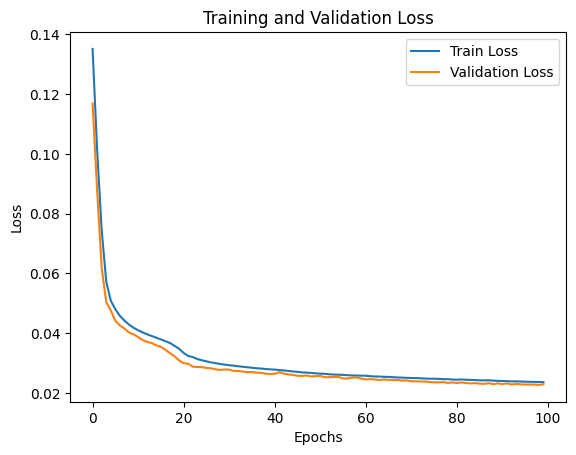

In [6]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=64, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

## Add some anomalies

From a totally different dataset

In [30]:
x_train_anomalies, x_test_anomalies = get_preprocessed_mnist(resized_size=32)

# For clarity, truncate to keep a similar dataset size.
x_train_anomalies = x_train_anomalies[:2000]
x_test_anomalies = x_test_anomalies[:1000]


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
# Compare the distributions
recover_emoji = autoencoder.predict(x_test)
recover_mnist = autoencoder.predict(x_test_anomalies)


32/32 [==============================] - 0s 7ms/step


In [32]:
from keras import backend as K
def image_mses(y_true, y_pred):
    # Compute MSE per-image, not overall
    return K.mean(K.square(y_pred - y_true), axis=[1,2,3]).numpy()

In [33]:
emoji_mses = image_mses(recover_emoji, x_test)
digits_mses = image_mses(recover_mnist, x_test_anomalies)

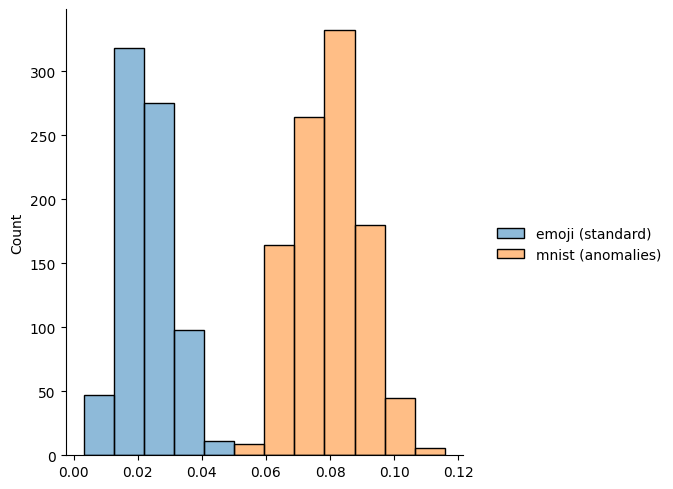

In [45]:
import seaborn as sns
sns.displot(
    data={
        "emoji (standard)": emoji_mses, 
        "mnist (anomalies)": digits_mses
    },
)

## Summary

As we can see, the categories are very well-separated.

This example (using totally different datasets) is maybe a little bit too easy for anomaly detection.

## Extensions 

Some other things you might want to try: 
 - Make the distinction harder: have the "standard" class be a specific digit (e.g. '8'), and treat every other digit as an anomaly.
 - Does an autoencoder work better/worse as a anomaly detector if we make it more/less powerful?  One intuition could be that, if it becomes too good at reconstruction, it might also be able to reconstruct anomalies reasonably well.  Can you build an example where this happens?